In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/dataset_1.csv',index_col='date',parse_dates = True)
df.index.asfreq = 'MS'

In [ ]:
df = df[(df['item_id'] == 1452) & (df['store_id'] == 0) & (df['state_id'] == 0)]

In [ ]:
df = df[df['d_value'] != -1]

In [ ]:
df = df.sort_index()

In [ ]:
df.head()

,item_id,store_id,state_id,sell_price,d_value
date,,,,,
2011-01-29,1452,0,0,0.7,5.0
2011-01-30,1452,0,0,0.7,1.0
2011-01-31,1452,0,0,0.7,3.0
2011-02-01,1452,0,0,0.7,0.0
2011-02-02,1452,0,0,0.7,15.0


<Axes: xlabel='date'>

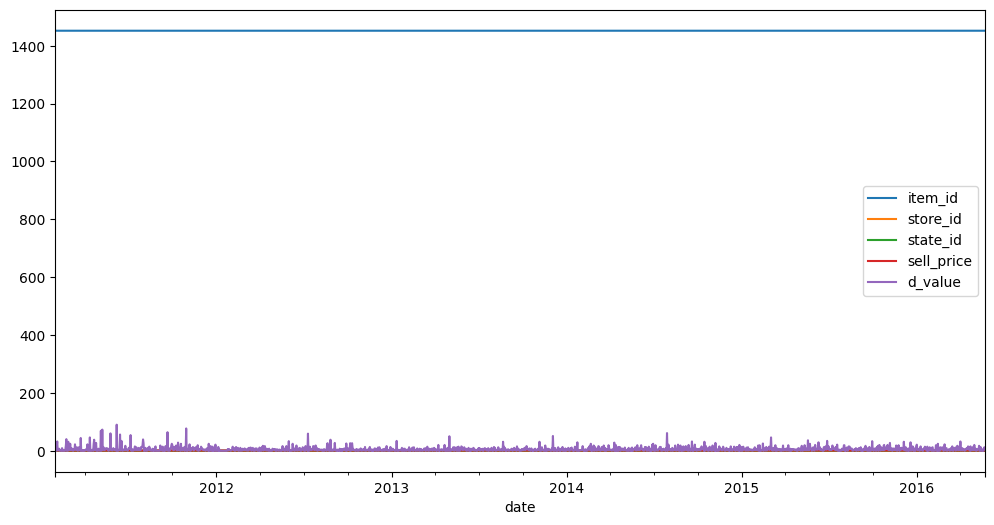

In [ ]:
df.plot(figsize=(12,6))

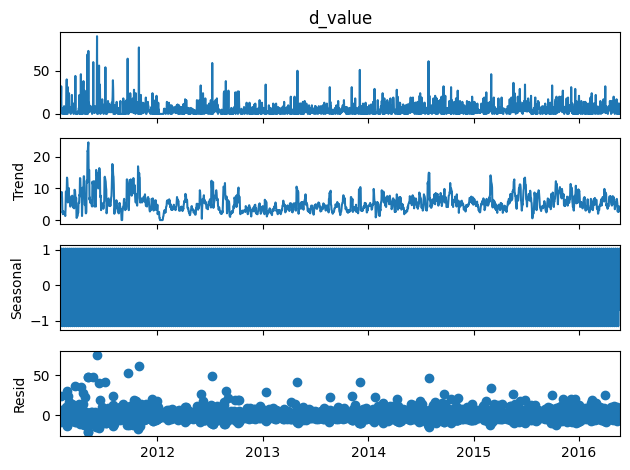

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['d_value'])
results.plot();

In [ ]:
train = df.iloc[:156]
test = df.iloc[156:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head(),df.tail()

(            item_id  store_id  state_id  sell_price  d_value
 date                                                        
 2011-01-29     1452         0         0         0.7      5.0
 2011-01-30     1452         0         0         0.7      1.0
 2011-01-31     1452         0         0         0.7      3.0
 2011-02-01     1452         0         0         0.7      0.0
 2011-02-02     1452         0         0         0.7     15.0,
             item_id  store_id  state_id  sell_price  d_value
 date                                                        
 2016-05-18     1452         0         0         0.7      5.0
 2016-05-19     1452         0         0         0.7      0.0
 2016-05-20     1452         0         0         0.7      7.0
 2016-05-21     1452         0         0         0.7     12.0
 2016-05-22     1452         0         0         0.7      6.0)

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.        , 0.        , 0.        , 0.5       , 0.05555556],
       [0.        , 0.        , 0.        , 0.5       , 0.01111111],
       [0.        , 0.        , 0.        , 0.5       , 0.03333333],
       [0.        , 0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       , 0.16666667],
       [0.        , 0.        , 0.        , 0.5       , 0.35555556],
       [0.        , 0.        , 0.        , 0.5       , 0.01111111],
       [0.        , 0.        , 0.        , 0.5       , 0.05555556],
       [0.        , 0.        , 0.        , 0.5       , 0.02222222],
       [0.        , 0.        , 0.        , 0.5       , 0.07777778]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input = 12
n_features = 5
generator = TimeseriesGenerator(scaled_train, scaled_train[:,-1], length=n_input, batch_size=1)

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.         0.         0.5        0.05555556 0.
 0.         0.         0.5        0.01111111 0.         0.
 0.         0.5        0.03333333 0.         0.         0.
 0.5        0.         0.         0.         0.         0.5
 0.16666667 0.         0.         0.         0.5        0.35555556
 0.         0.         0.         0.5        0.01111111 0.
 0.         0.         0.5        0.05555556 0.         0.
 0.         0.5        0.02222222 0.         0.         0.
 0.5        0.07777778 0.         0.         0.         0.5
 0.         0.         0.         0.         0.5        0.01111111]
Predict this y: 
 [0.01111111]


In [ ]:
X.shape

(1, 12, 5)

In [ ]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train[:,-1], length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100)               42400     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 42501 (166.02 KB)
Trainable params: 42501 (166.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=50)

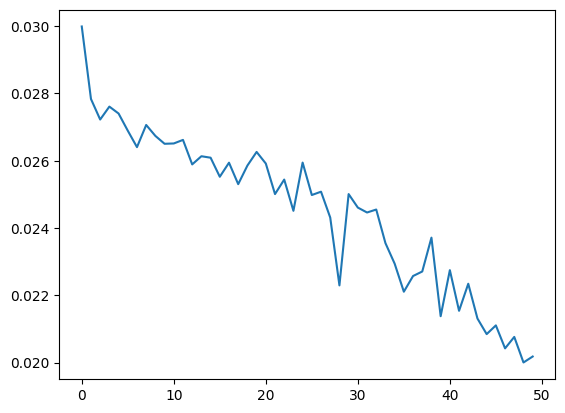

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 0s 188ms/step


array([[0.16480064]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.        , 0.        , 0.        , 0.        , 0.13333333])

In [ ]:
scaled_test_copy = scaled_test.copy()
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)
    new_row = np.append(scaled_test_copy[i,:-1], current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[new_row]],axis=1)

    scaled_test_copy[i, -1] = current_pred


test_predictions

In [ ]:
test.head()

,item_id,store_id,state_id,sell_price,d_value
date,,,,,
2011-07-04,1452,0,0,0.68,12.0
2011-07-05,1452,0,0,0.68,7.0
2011-07-06,1452,0,0,0.68,54.0
2011-07-07,1452,0,0,0.68,2.0
2011-07-08,1452,0,0,0.68,0.0


In [ ]:
true_predictions = scaler.inverse_transform(scaled_test_copy)
test['Predictions'] = true_predictions[:,-1]

<ipython-input-371-fd1c90db720d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions[:,-1]


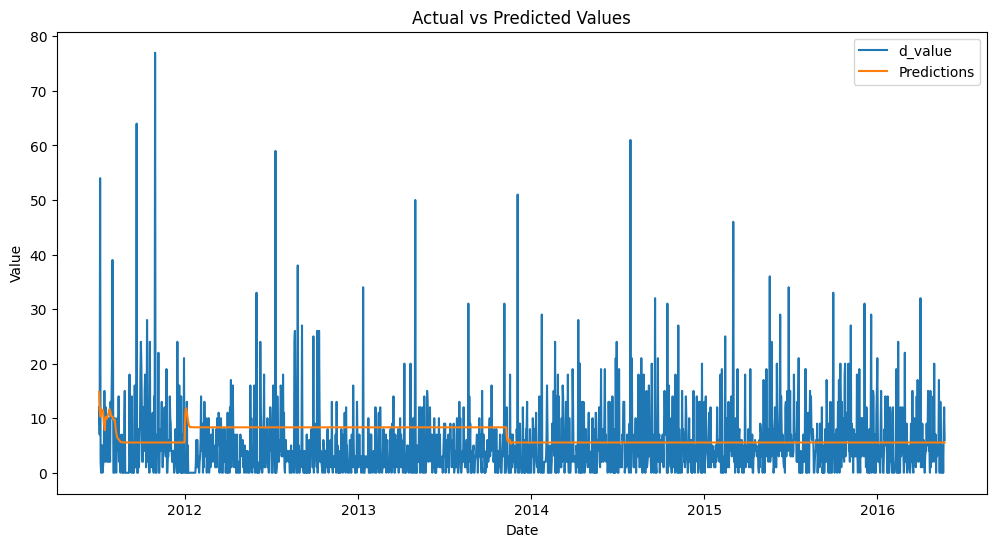

In [ ]:
plt.figure(figsize=(12, 6))

# Plot 'd_value'
plt.plot(test.index, test['d_value'], label='d_value')

# Plot 'Predictions'
plt.plot(test.index, test['Predictions'], label='Predictions')

# Set plot title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()  # Show legend

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['d_value'],test['Predictions']))
print(rmse)

7.221561238951169
